<a href="https://colab.research.google.com/github/contatofe/Estudos-e-Desafios/blob/main/Desafio_2_Regress%C3%A3o_Udemy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Instalação do Algoritmo
!pip install lightgbm --quiet
!pip install catboost --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.diagnostic import lilliefors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#Analisando o Dataframe

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Arquivos - Dados/insurance.csv')

In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
#O dataframe não possui dados nulos, e os tipos estão correspondentes aos encontrados nos dados.

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
# O df possui 1 lina duplicada, por isso vamos retirá-la.

df.duplicated().sum()

1

In [ ]:
# retirando duplicada.

df.drop_duplicates(inplace=True)

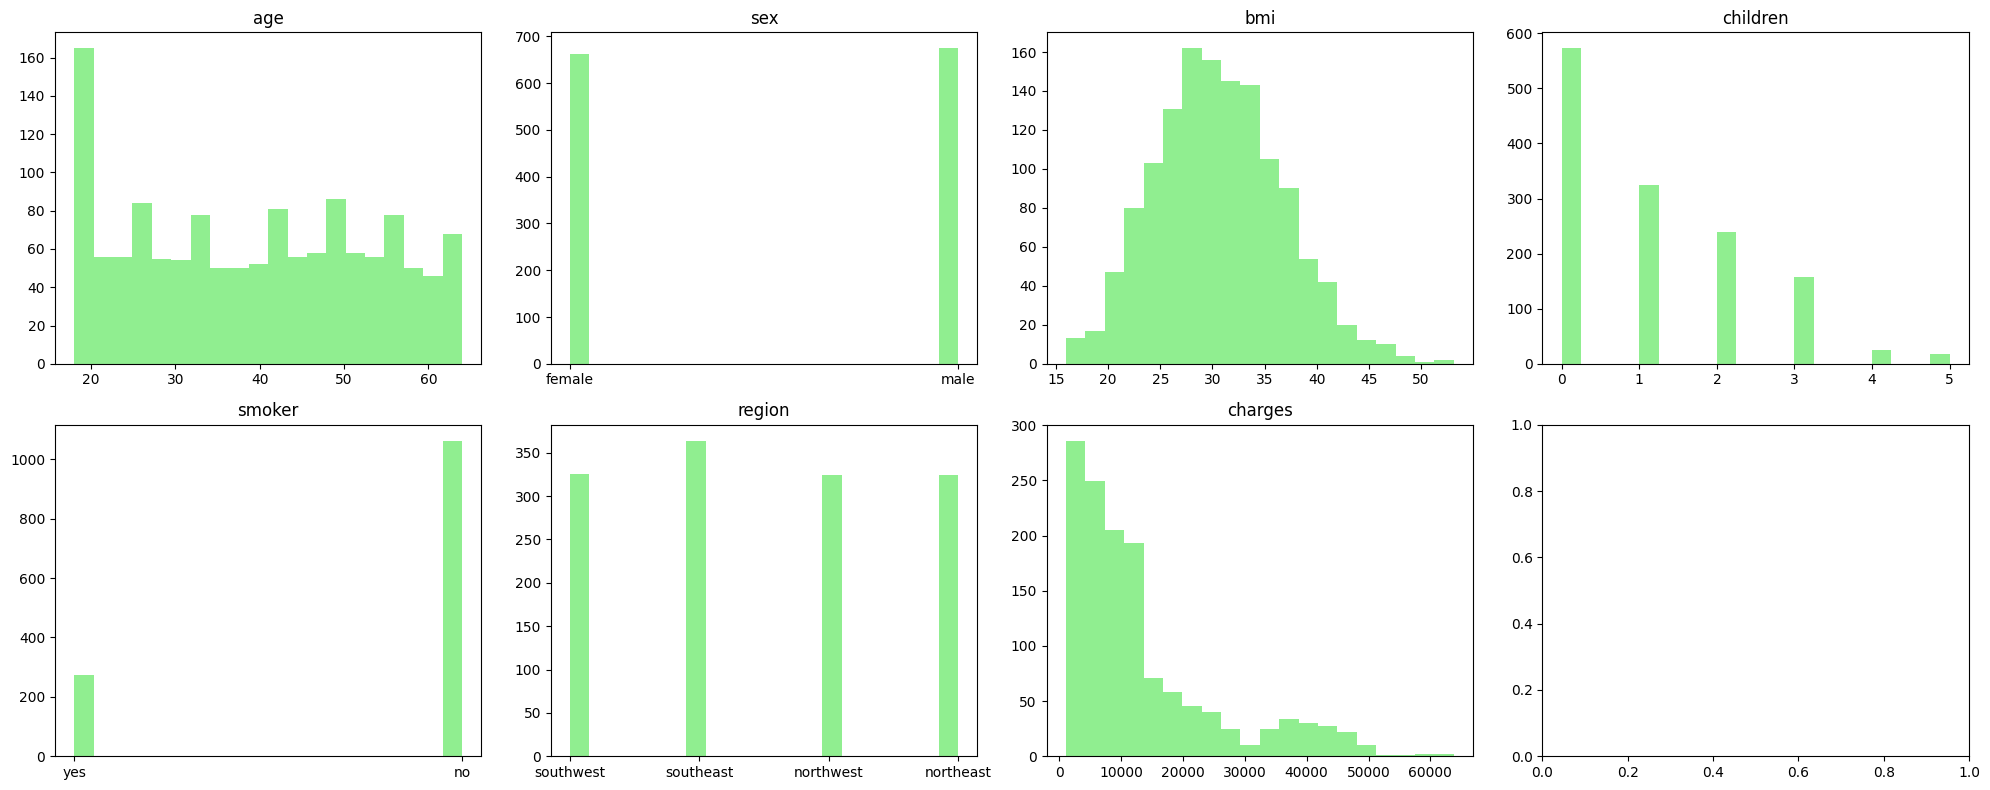

In [ ]:
#Visualizando os histogramas de cada coluna

num_columns = 4
num_rows = -(-len(df.columns) // num_columns)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 4 * num_rows))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    ax = axes[i]
    ax.hist(df[column], bins=20, color='lightgreen')
    ax.set_title(column)

plt.tight_layout()
plt.show()

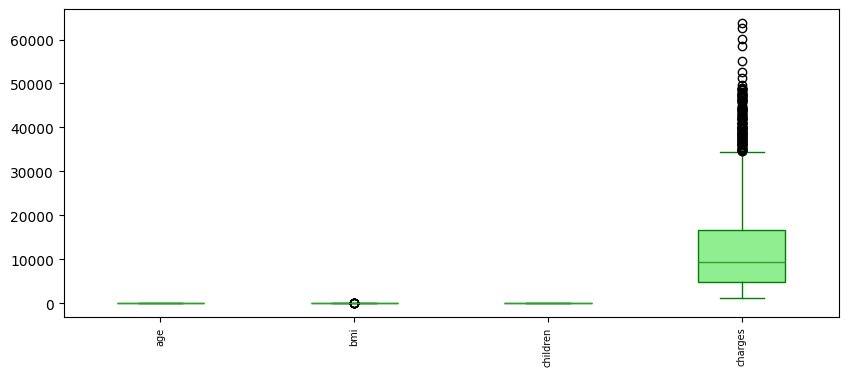

In [ ]:
#Visualizando Boxplots das colunas. Apesar de haver uma série de valores outliers, optei por manter, pois as observações parecem ser todas reais.

df.boxplot(figsize=(10,4), grid=False, patch_artist=True, boxprops=dict(facecolor='lightgreen', color='green'), whiskerprops=dict(color='green'), capprops=dict(color='green'))
plt.xticks(rotation=90, fontsize=7)
plt.show()

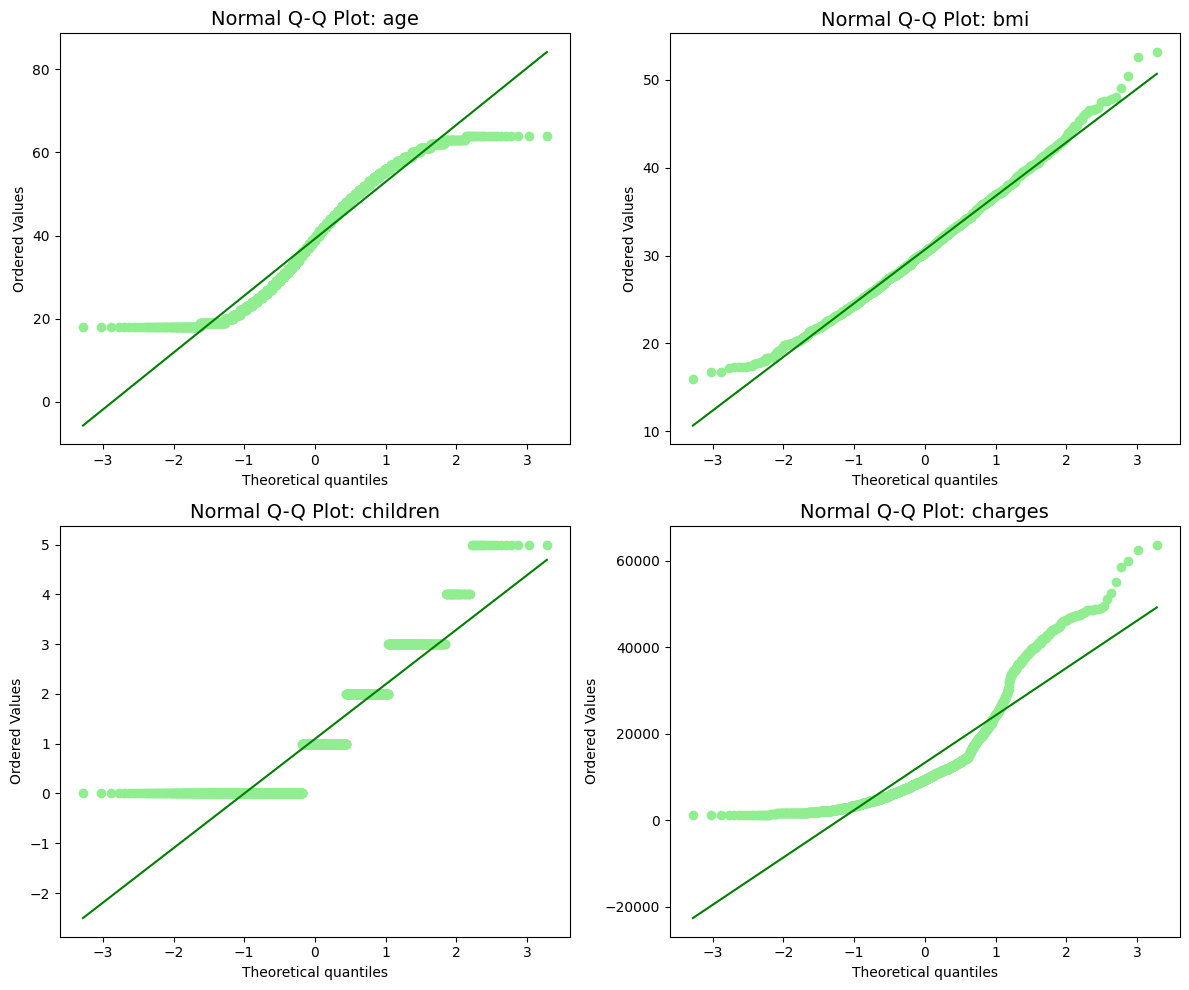

In [ ]:
#Análise de normalidade - Gráfico. Somente os dados de BMI parecem se aproximar da curva normal.

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
columns = ["age", "bmi", "children", "charges"]
colors = ["#a8e6cf", "#dcedc1", "#66bb6a", "#388e3c"]

for ax, col in zip(axes.flatten(), columns):
    stats.probplot(df[col], dist="norm", plot=ax)
    ax.get_lines()[0].set_color('lightgreen')
    ax.get_lines()[1].set_color("green")
    ax.set_title(f"Normal Q-Q Plot: {col}", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
#Análise de normalidade - Testes. Com os testes Shapiro-Wilk e Kolgomorov-Smirnov conseguimos notar que nenhuma variável consegue se encaixar na curva normal para p-valor > 0.05.

for col in columns:
    print(f"Coluna: {col}")
    print("\nTeste Shapiro-Wilk")
    stat_shapiro, p_shapiro = stats.shapiro(df[col])
    print(f"Estatística de teste: {stat_shapiro:.4f}")
    print(f"p-value: {p_shapiro:.4f}\n")

    print("Teste Lilliefors (Kolmogorov-Smirnov com correção)")
    stat_lillie, p_lillie = lilliefors(df[col], dist="norm")
    print(f"Estatística de teste: {stat_lillie:.4f}")
    print(f"p-value: {p_lillie:.4f}\n")
    print("=" * 50)

Coluna: age

Teste Shapiro-Wilk
Estatística de teste: 0.9449
p-value: 0.0000

Teste Lilliefors (Kolmogorov-Smirnov com correção)
Estatística de teste: 0.0788
p-value: 0.0010

Coluna: bmi

Teste Shapiro-Wilk
Estatística de teste: 0.9939
p-value: 0.0000

Teste Lilliefors (Kolmogorov-Smirnov com correção)
Estatística de teste: 0.0264
p-value: 0.0408

Coluna: children

Teste Shapiro-Wilk
Estatística de teste: 0.8234
p-value: 0.0000

Teste Lilliefors (Kolmogorov-Smirnov com correção)
Estatística de teste: 0.2469
p-value: 0.0010

Coluna: charges

Teste Shapiro-Wilk
Estatística de teste: 0.8148
p-value: 0.0000

Teste Lilliefors (Kolmogorov-Smirnov com correção)
Estatística de teste: 0.1885
p-value: 0.0010



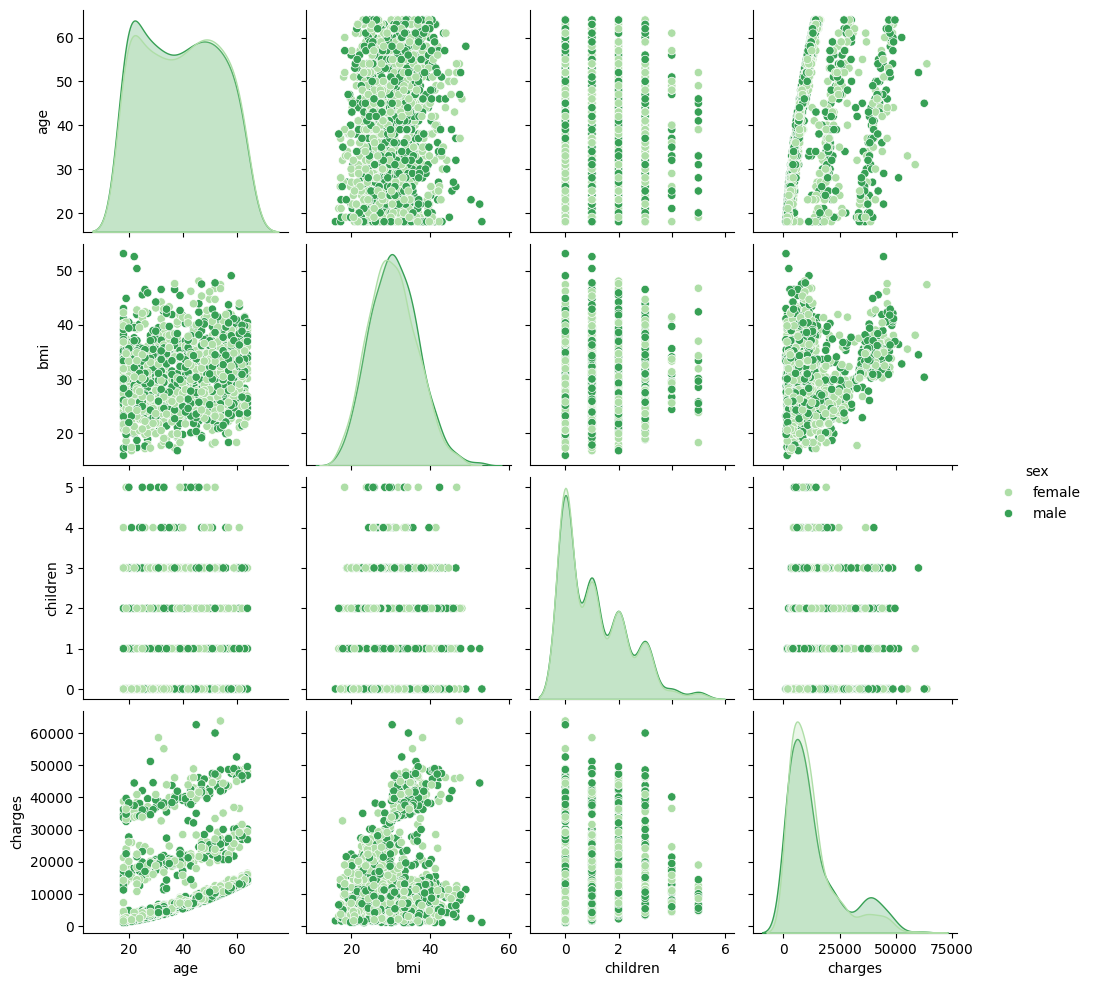

In [ ]:
# Analisando as correlações - Gráfico. Pela análise gráfica, só parece existir alguma correlação visível da coluna age com a variável dependente "charges".

sns.pairplot(df,hue="sex",palette = 'Greens');
plt.show()

In [ ]:
#Analisando as correlações - Teste. Como as curvas não tiveram aspecto normal, optei por utilizar a correlação de Pearson para avaliá-las.
#Como resultado somente a coluna age demonstrou uma correlação intermediária com a variável dependente.

for col in ['age','bmi','children']:
    print(f"Coluna: {col}")
    coef,p = stats.spearmanr(df[col], df.charges)
    print('\nCoeficiente de correlação: {}\n'.format(coef))
    print("=" * 50)

Coluna: age

Coeficiente de correlação: 0.5335232787189862

Coluna: bmi

Coeficiente de correlação: 0.11958495819244366

Coluna: children

Coeficiente de correlação: 0.13220013322835855



In [ ]:
#Outra forma de visualizar.
df.select_dtypes(include=["number"]).corr(method="spearman")['charges']

,charges
age,0.533523
bmi,0.119585
children,0.132200
charges,1.000000


# Pré Processamento

In [ ]:
previsores = df.drop(columns=['charges'])
alvo = df['charges']

In [ ]:
#Transformando variáveis categóricas em numéricas.

le = LabelEncoder()
previsores['sex'] = le.fit_transform(previsores['sex'])
previsores['smoker'] = le.fit_transform(previsores['smoker'])

previsores = pd.concat([previsores, pd.get_dummies(previsores['region'])], axis=1)
previsores.drop(columns=['region'], inplace=True)

In [ ]:
previsores

,age,sex,bmi,children,smoker,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,False,False,False,True
1,18,1,33.770,1,0,False,False,True,False
2,28,1,33.000,3,0,False,False,True,False
3,33,1,22.705,0,0,False,True,False,False
4,32,1,28.880,0,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,False,True,False,False
1334,18,0,31.920,0,0,True,False,False,False
1335,18,0,36.850,0,0,False,False,True,False
1336,21,0,25.800,0,0,False,False,False,True


#Separando bases de treino e teste

In [ ]:
x_treino, x_teste, y_treino, y_teste = train_test_split(previsores, alvo, test_size = 0.3, random_state = 42)

# Criando modelos

##Regressão linear

In [ ]:
#previsões
regressor = LinearRegression()
regressor.fit(x_treino, y_treino)
y_pred = regressor.predict(x_teste)

In [ ]:
#métricas - teste
print(f'R2 = {(r2_score(y_teste, y_pred)):.2%}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_teste, y_pred)):.2f}')
print(f'MAE = {mean_absolute_error(y_teste, y_pred):.2f}')

R2 = 77.24%
RMSE = 6240.21
MAE = 4181.82


In [ ]:
#validação cruzada
kfold = KFold(n_splits = 30, shuffle=True, random_state = 42)
modelo = regressor
resultado = cross_val_score(modelo, previsores, alvo, cv = kfold)
print("R2 Médio: %.2f%%" % (resultado.mean() * 100.0))

R2 Médio: 72.70%


##Máquina de vetores de suporte (SVM)

In [ ]:
#previsões
svm = SVR(kernel='poly', C = 0.1, gamma = 'auto')
svm.fit(x_treino, y_treino)
y_pred = svm.predict(x_teste)

In [ ]:
#métricas - teste
print(f'R2 = {(r2_score(y_teste, y_pred)):.2%}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_teste, y_pred)):.2f}')
print(f'MAE = {mean_absolute_error(y_teste, y_pred):.2f}')

R2 = 83.13%
RMSE = 5373.08
MAE = 2295.72


In [ ]:
#validação cruzada
kfold = KFold(n_splits = 5, shuffle=True, random_state = 42)
modelo = svm
resultado = cross_val_score(modelo, previsores, alvo, cv = kfold)
print("R2 Médio: %.2f%%" % (resultado.mean() * 100.0))

R2 Médio: 81.35%


## Árvore de decisão

In [ ]:
#previsões
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(x_treino, y_treino)
y_pred = tree.predict(x_teste)

In [ ]:
#métricas - teste
print(f'R2 = {(r2_score(y_teste, y_pred)):.2%}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_teste, y_pred)):.2f}')
print(f'MAE = {mean_absolute_error(y_teste, y_pred):.2f}')

R2 = 87.23%
RMSE = 4674.52
MAE = 2501.64


In [ ]:
#validação cruzada
kfold = KFold(n_splits = 30, shuffle=True, random_state = 42)
modelo = tree
resultado = cross_val_score(modelo, previsores, alvo, cv = kfold)
print("R2 Médio: %.2f%%" % (resultado.mean() * 100.0))

R2 Médio: 84.01%


## Random Forest

In [ ]:
#previsões
forest = RandomForestRegressor(n_estimators=200, max_depth = 5)
forest.fit(x_treino, y_treino)
y_pred = forest.predict(x_teste)

In [ ]:
#métricas - teste
print(f'R2 = {(r2_score(y_teste, y_pred)):.2%}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_teste, y_pred)):.2f}')
print(f'MAE = {mean_absolute_error(y_teste, y_pred):.2f}')

R2 = 87.48%
RMSE = 4628.75
MAE = 2561.22


In [ ]:
#validação cruzada
kfold = KFold(n_splits = 30, shuffle=True, random_state = 42)
modelo = forest
resultado = cross_val_score(modelo, previsores, alvo, cv = kfold)
print("R2 Médio: %.2f%%" % (resultado.mean() * 100.0))

R2 Médio: 84.77%


## XGBoost

In [ ]:
#previsões
xg = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.05)
xg.fit(x_treino, y_treino)
y_pred = xg.predict(x_teste)

In [ ]:
#métricas - teste
print(f'R2 = {(r2_score(y_teste, y_pred)):.2%}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_teste, y_pred)):.2f}')
print(f'MAE = {mean_absolute_error(y_teste, y_pred):.2f}')

R2 = 87.79%
RMSE = 4570.70
MAE = 2486.51


In [ ]:
#validação cruzada
kfold = KFold(n_splits = 30, shuffle=True, random_state = 42)
modelo = xg
resultado = cross_val_score(modelo, previsores, alvo, cv = kfold)
print("R2 Médio: %.2f%%" % (resultado.mean() * 100.0))

R2 Médio: 84.95%


##LightGBM

In [ ]:
#previsões
lgbm = LGBMRegressor(num_leaves=30, max_depth=4, learning_rate=0.1, n_estimators=50, verbose=-1)
lgbm.fit(x_treino, y_treino)
y_pred = lgbm.predict(x_teste)

In [ ]:
#métricas - teste
print(f'R2 = {(r2_score(y_teste, y_pred)):.2%}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_teste, y_pred)):.2f}')
print(f'MAE = {mean_absolute_error(y_teste, y_pred):.2f}')

R2 = 87.85%
RMSE = 4560.51
MAE = 2492.34


In [ ]:
#validação cruzada
kfold = KFold(n_splits = 30, shuffle=True, random_state = 42)
modelo = lgbm
resultado = cross_val_score(modelo, previsores, alvo, cv = kfold)
print("R2 Médio: %.2f%%" % (resultado.mean() * 100.0))

R2 Médio: 84.80%


##Catboost

In [ ]:
#previsões
cat = CatBoostRegressor(iterations=100, learning_rate=0.1, depth = 5, verbose=False)
cat.fit(x_treino, y_treino)
y_pred = cat.predict(x_teste)

In [ ]:
#métricas - teste
print(f'R2 = {(r2_score(y_teste, y_pred)):.2%}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_teste, y_pred)):.2f}')
print(f'MAE = {mean_absolute_error(y_teste, y_pred):.2f}')

R2 = 87.31%
RMSE = 4659.89
MAE = 2580.12


In [ ]:
#validação cruzada
kfold = KFold(n_splits = 30, shuffle=True, random_state = 42)
modelo = cat
resultado = cross_val_score(modelo, previsores, alvo, cv = kfold)
print("R2 Médio: %.2f%%" % (resultado.mean() * 100.0))

R2 Médio: 84.60%


##Resultados

**Regressão linear** - R2: 77.24% | RMSE: 6240.21 | R2 Validação Cruzada: 72.70%

**SVM** - R2: 83.13% | RMSE: 5373.08 | R2 Validação Cruzada: 81.35%

**Árvore de Decisão** - R2: 87.23% | RMSE: 4674.52 | R2 Validação Cruzada: 84.01%

**Random Forest** - R2: 87.48% | RMSE: 4627.77 | R2 Validação Cruzada: 84.79%

**XGBoost** - R2: 87.79% | RMSE: 4570.70 | R2 Validação Cruzada: 84.95%

**LightGBM** - R2: 87.85% | RMSE: 4560.51 | R2 Validação Cruzada: 84.80%

**Catboost** - R2: 87.31% | RMSE: 4659.89 | R2 Validação Cruzada: 84.60%

---

Portanto, o modelo que melhor performou para esse dataframe foi o LightGBM, apesar de ficar muito próximo dos modelos XGBoost e Random Forest.